In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from util import CLASS_NAME_TO_ID, visualize

In [2]:
data_dir = './DataSet/'
data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))
data_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24057,fff2b15ad6007d0e,activemil,Truck,1,0.277344,0.622656,0.226389,0.859722,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
24058,fff376d20410e4c9,xclick,Bus,1,0.295625,0.558750,0.306667,0.397500,1,0,...,1,0,0.424375,0.316250,0.295625,0.558750,0.306667,0.397500,0.382500,0.335833
24059,fff376d20410e4c9,xclick,Bus,1,0.348125,0.701250,0.423333,0.744167,0,0,...,1,0,0.478750,0.493125,0.348125,0.701250,0.423333,0.744167,0.537500,0.523333
24060,fffde5953a818927,xclick,Bus,1,0.277500,0.605625,0.565000,0.795833,0,0,...,0,0,0.488125,0.277500,0.517500,0.605625,0.565000,0.670000,0.795833,0.704167


In [3]:
index = 0
image_files = [fn for fn in os.listdir('./DataSet/train/') if fn.endswith('jpg')]
image_file = image_files[index]
image_file

'0000599864fd15b3.jpg'

In [4]:
image_path = os.path.join('./DataSet/train/', image_file)
image_path

'./DataSet/train/0000599864fd15b3.jpg'

In [5]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(170, 256, 3)

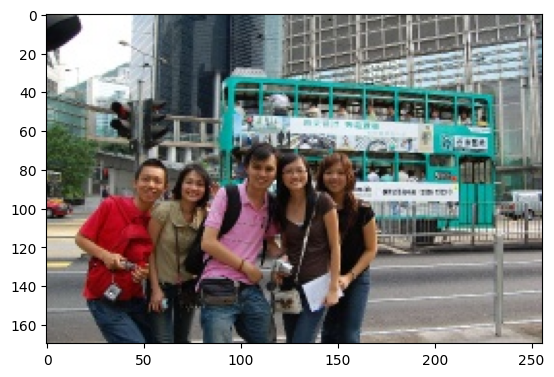

In [6]:
plt.imshow(image)

In [7]:
image_id = image_file.split('.')[0]
image_id

'0000599864fd15b3'

In [8]:
meta_data = data_df[data_df['ImageID'] == image_id]
meta_data

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.34375,0.90875,0.156162,0.650047,1,0,...,0,0,0.421875,0.34375,0.795,0.90875,0.156162,0.5127,0.650047,0.457197


In [9]:
cate_names = meta_data['LabelName'].values
cate_names

array(['Bus'], dtype=object)

In [10]:
bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
bboxes

array([[0.34375 , 0.90875 , 0.156162, 0.650047]])

In [11]:
img_H, img_W, _ = image.shape
img_H, img_W

(170, 256)

In [12]:
class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
class_ids

[0]

In [13]:
# 'XMin', 'XMax', 'YMin', 'YMax'
unnorm_bboxes = bboxes.copy()
# unnorm_bboxes

# XMax, YMin의 자리를 바꿈
# 'XMin', 'YMin', 'XMax', 'YMax'
unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]

# 'XMin', 'YMin' -= 'XMin', 'YMin'
# 'XMax' - 'XMin' , 'YMax' - 'YMin'
# 'XMin', 'YMin', W, H
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]

# 'XMin', 'YMin' += (W, H / 2)
# 'XMin' + (W / 2), 'YMin' + (H / 2)
# X_Cen, Y_Cen, W, H
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)

# X_cen, Y_cen, W, H
unnorm_bboxes

array([[0.62625  , 0.4031045, 0.565    , 0.493885 ]])

In [14]:
unnorm_bboxes[:, [0, 2]] *= img_W
unnorm_bboxes[:, [1, 3]] *= img_H
unnorm_bboxes

array([[160.32    ,  68.527765, 144.64    ,  83.96045 ]])

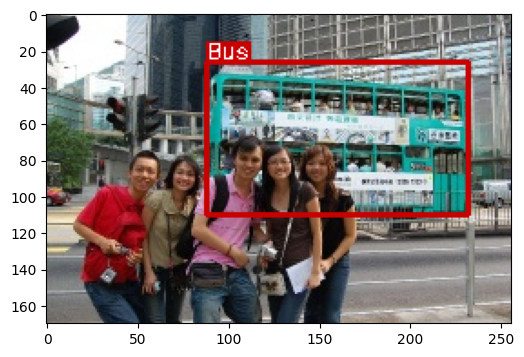

In [15]:
canvas = visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [18]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join('./DataSet/train/', image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_id = image_file.split('.')[0]
    meta_data = data_df[data_df['ImageID'] == image_id]
    cate_names = meta_data['LabelName'].values
    bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
    img_H, img_W, _ = image.shape
    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)
    
    unnorm_bboxes[:, [0, 2]] *= img_W
    unnorm_bboxes[:, [1, 3]] *= img_H
    
    canvas = visualize(image, unnorm_bboxes, class_ids)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [24]:
class Detection_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]
        self.transformer = transformer
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)
        img_H, img_W, _ = image.shape
        if self.transformer:
            image = self.transformer(image)
            _, img_H, img_W = image.shape
            
        bboxes[:, [0, 2]] *= img_W
        bboxes[:, [1, 3]] *= img_H
        
        target = {}
        target['boxes'] = torch.Tensor(bboxes).float()
        target['labels'] = torch.Tensor(class_ids).long()
        
        return image, target, filename
    
    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image
    
    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = data_df[data_df['ImageID'] == image_id]
        cate_names = meta_data['LabelName'].values
        class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
        
        bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
        bboxes[:, [1, 2]] = bboxes[:, [2, 1]]
        return bboxes, class_ids

In [25]:
data_dir = './DataSet/'
dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=None)

In [26]:
dataset[0]

(array([[[ 80,  87,  80],
         [ 86,  93,  86],
         [ 93,  95,  94],
         ...,
         [ 93,  91,  94],
         [ 77,  78,  82],
         [121, 125, 128]],
 
        [[ 79,  83,  82],
         [ 76,  80,  79],
         [ 79,  83,  84],
         ...,
         [ 82,  80,  83],
         [ 92,  93,  95],
         [121, 125, 126]],
 
        [[ 74,  74,  82],
         [ 68,  71,  78],
         [ 71,  74,  79],
         ...,
         [ 85,  83,  84],
         [ 98, 100,  99],
         [116, 122, 120]],
 
        ...,
 
        [[106, 102,  99],
         [108, 104, 101],
         [108, 104, 101],
         ...,
         [165, 157, 144],
         [150, 142, 129],
         [133, 125, 112]],
 
        [[108, 103,  99],
         [103,  98,  94],
         [111, 108, 103],
         ...,
         [166, 160, 148],
         [160, 154, 142],
         [151, 145, 133]],
 
        [[117, 112, 108],
         [116, 111, 107],
         [122, 119, 114],
         ...,
         [173, 167, 155],
  

In [44]:
index = 500
image, target, filename = dataset[index]

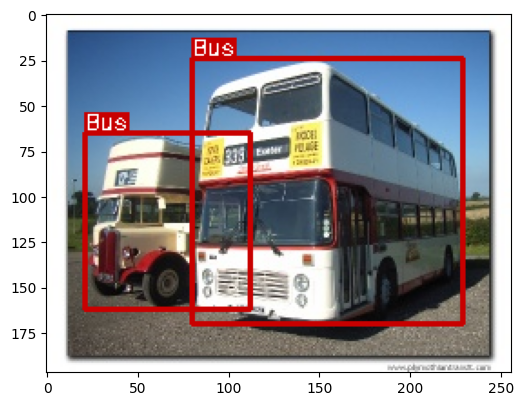

In [45]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()

n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = visualize(image, bboxes, class_ids)

plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [32]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image, target, filename = dataset[index]
    
    boxes = target['boxes'].numpy()
    class_ids = target['labels'].numpy()

    n_obj = boxes.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
    bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

    canvas = visualize(image, bboxes, class_ids)

    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…